In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

In [2]:
import sklearn

In [3]:
import datetime

# Read data

In [4]:
from data_cleaner import get_cleaned_data

df = get_cleaned_data("final_training_xy_2.csv")


Start Preprocessing for final_training_xy_2.csv...
- 1486 tickers selected. m-factors added.
- NA rows for m_ret_next are dropped.
- 65 good columns selected.
- Fill NA complete.
- Trading indicators added.
- Final NA-drop dropped 0 rows
Data cleaning complete.


In [3]:
models = {} # store all the models

In [5]:
features = pd.read_csv("rfc_features.csv").iloc[:, -1].tolist()

# Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df[features].copy()
y = np.where(df.m_ret_next > 0, 1, 0) # negative return as 0, positive return as 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X.shape

(70524, 59)

In [9]:
#%% Result Printing helper
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def result(y,pred,name):

    text = '\n'
    text += 30*'-' + name + 30*'-' + '\n'

    cm = confusion_matrix(y, pred)
    accuracy = accuracy_score(y, pred)*100
    # F1_score = f1_score(y,pred)*100

    text += 'Confusion matrix:\n %s'%cm
    text += '\nAccuracy: %.8f %%' % accuracy
    # text += '\nf1 score: %.4f %%' % F1_score

    # summary report
    cs = classification_report(y, pred, digits=6)
    text += '\nClassification Summary:\n%s'%cs

    return text

# Defatul Parameter

In [8]:
#%% Defatul Parameter
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred_base = rfc.predict(X_test)

In [9]:
name = "Default Params"
base_result = result(y_test, y_pred_base, name)
print(base_result)

joblib.dump(rfc,"best_models/" + name)
models[name] = rfc


------------------------------Default Params------------------------------
Confusion matrix:
 [[3783 2469]
 [1671 6182]]
Accuracy: 70.64870613 %
Classification Summary:
              precision    recall  f1-score   support

           0   0.693619  0.605086  0.646335      6252
           1   0.714599  0.787215  0.749152      7853

    accuracy                       0.706487     14105
   macro avg   0.704109  0.696151  0.697743     14105
weighted avg   0.705300  0.706487  0.703579     14105



# RandomSearchCV

In [10]:
#%% Random search CV to find an overall tree structure

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

criterion = ['entropy']
max_features = ['auto', 'log2', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

# Whether bootstrap samples are used when building trees. 
# If False, the whole dataset is used to build each tree.
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'criterion': ['entropy'], 'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:
## Will run 5 hours +
# rfc_random = RandomizedSearchCV(estimator = RandomForestClassifier(), 
#                                 param_distributions = random_grid, 
#                                 n_iter = 100, cv = 3, verbose=2, n_jobs = 5)

# rfc_random.fit(X_train, y_train)
# print(rfc_grid.best_params_)
# print(rfc_grid.best_score_)

# Best RandomSearchCV

In [14]:
rand_best_params = {'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

rfc_random = RandomForestClassifier()
rfc_random.set_params(**rand_best_params)
rfc_random.fit(X_train, y_train)

y_pred_rand = rfc_random.predict(X_test)
name = "Random CV"
models[name] = rfc_random
rcv_result = result(y_test, y_pred_rand, name)
print(rcv_result)

joblib.dump(rfc_random,"best_models/" + name)
models[name] = rfc_random


------------------------------Random CV------------------------------
Confusion matrix:
 [[3670 2582]
 [1464 6389]]
Accuracy: 71.31513648 %
Classification Summary:
              precision    recall  f1-score   support

           0   0.714842  0.587012  0.644651      6252
           1   0.712184  0.813574  0.759510      7853

    accuracy                       0.713151     14105
   macro avg   0.713513  0.700293  0.702081     14105
weighted avg   0.713362  0.713151  0.708599     14105



# Cost-complexity Pruning (CCP)

Fitting 67/67 
Number of nodes in the last tree is: 111 with ccp_alpha: 0.0003471357886377993


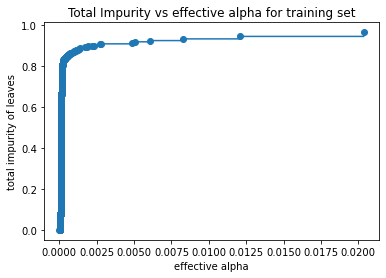

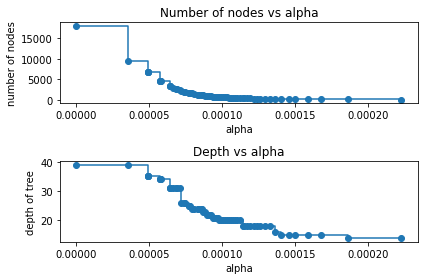

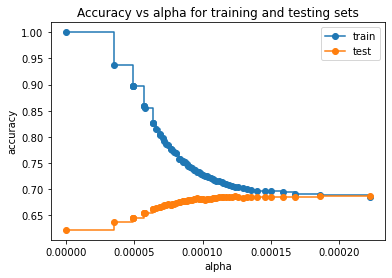

In [51]:
#%% Choose good ccp_alpha by decision tree
import ccp_alpha_chooser

ccp_alpha_chooser.evaluate(X_train, X_test, y_train, y_test)

## Grid Search CV

In [17]:
#%% Grid search CV to find an overall tree structure

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [1000, 1800],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [3,4,5],
    'max_features': ['auto'],
    'max_depth': [50, 60],
    'criterion': ['entropy'],
    'bootstrap': [True],
    'oob_score': [True, False],
    'ccp_alpha': [0, 0.00005, 0.000075, 0.0001]
    }

print(param_grid)

{'n_estimators': [1000, 1800], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [3, 4, 5], 'max_features': ['auto'], 'max_depth': [50, 60], 'criterion': ['entropy'], 'bootstrap': [True], 'oob_score': [True, False], 'ccp_alpha': [0, 5e-05, 7.5e-05, 0.0001]}


In [18]:
## Will run 5 hour +
# rfc_grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
#                           cv = 3, n_jobs = 11, verbose = 3)

# rfc_grid.fit(X_train, y_train)
# print(rfc_grid.best_params_)
# print(rfc_grid.best_score_)

## Best GridSearchCV

In [19]:
#%% Best Grid Search

best_params = {'bootstrap': True,
 'ccp_alpha': 7.5e-05,
 'criterion': 'entropy',
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'oob_score': True}

rfc_grid = RandomForestClassifier(random_state=0)
rfc_grid.set_params(**best_params)
rfc_grid.fit(X_train, y_train)

y_pred = rfc_grid.predict(X_test)
name = "Best RFC"
models[name] = rfc_grid
print(result(y_test, y_pred, name))

joblib.dump(rfc_grid,"best_models/" + name)
models[name] = rfc_grid


------------------------------Best RFC------------------------------
Confusion matrix:
 [[3672 2580]
 [1462 6391]]
Accuracy: 71.34349521 %
Classification Summary:
              precision    recall  f1-score   support

           0   0.715232  0.587332  0.645003      6252
           1   0.712407  0.813829  0.759748      7853

    accuracy                       0.713435     14105
   macro avg   0.713819  0.700581  0.702375     14105
weighted avg   0.713659  0.713435  0.708887     14105



# BEST PARAMETERS AND MODEL

In [21]:
best_params = {'bootstrap': True,
 'ccp_alpha': 7.5e-05,
 'criterion': 'entropy',
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'oob_score': True}

## Finally, fit on the whole training set

In [2]:
name = "grow_fall_rfc_model"

In [86]:
rfc = RandomForestClassifier(random_state=0)
rfc.set_params(**best_params)
rfc.fit(X, y)
joblib.dump(rfc,"best_models/" + name)

['best_models/grow_fall_rfc_model']

In [3]:
rfc_test = joblib.load("best_models/" + name)

In [10]:
# In-sample performance
y_pred = rfc_test.predict(X)
print(result(y, y_pred, name))


------------------------------grow_fall_rfc_model------------------------------
Confusion matrix:
 [[29910  1626]
 [  764 38224]]
Accuracy: 96.61108275 %
Classification Summary:
              precision    recall  f1-score   support

           0   0.975093  0.948440  0.961582     31536
           1   0.959197  0.980404  0.969685     38988

    accuracy                       0.966111     70524
   macro avg   0.967145  0.964422  0.965633     70524
weighted avg   0.966305  0.966111  0.966061     70524



In [15]:
joblib.dump(rfc_test, "grow_fall_rfc_model.dat", compress=9)

['grow_fall_rfc_model.dat']